In [1]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 20.4 MB/s 


In [2]:
import pandas as pd
import urllib.request
import sentencepiece as spm
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from collections import Counter
import csv

In [16]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7f3345c1bfd0>)

In [42]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [3]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.5 MB/s 
     |████████████████████████████████| 453 kB 63.1 MB/s 
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 1.87 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-09-12 17:18:16--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.1

In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
file_path = '/content/stopwords-ko.txt'

with open(file_path) as f:
    stopwords = f.readlines()
stopwords = [line.rstrip('\n') for line in stopwords]
print(stopwords[:15])

['가', '가까스로', '가령', '각', '각각', '각자', '각종', '갖고말하자면', '같다', '같이', '개의치않고', '거니와', '거바', '거의', '것']


In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
def tokenize_and_remove_stopwords(data, stopwords, tokenizer):
    result = []

    for sentence in data:
        curr_data = []
        curr_data = tokenizer.morphs(sentence) # mecab 형태소 분석 tokenizer
        curr_data = [word for word in curr_data if not word in stopwords] # 불용어 제거
        result.append(curr_data)
    return result

def load_data(train_data, test_data, num_words=10000):

    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # Nan 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 토큰화 및 불용어 제거
    x_train = tokenize_and_remove_stopwords(train_data['document'], stopwords, tokenizer)
    x_test = tokenize_and_remove_stopwords(test_data['document'], stopwords, tokenizer)

    # 단어장 만드는 중...
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index


# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것을 말합니다.

def get_encoded_sentence(sentence, word_to_index): ##### 텍스트 -> 숫자
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. ##### 숫자 -> 텍스트
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [ ]:
print(x_train[10])

[2, 4, 35, 202, 7, 480]


In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
get_decoded_sentence(x_train[10], index_to_word)

'. 진짜 짱 다 ♥'

In [ ]:
# 데이터 셋 내 문장 길이 분포
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를 들면 최대길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +2 * np.std(num_tokens)

maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

문장길이 평균 : 15.269884662049053
문장길이 최대 : 116
문장길이 표준편차 :  12.221159250454772
pad_sequences maxlen :  39
전체 문장의 0.9339814373985738%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
# 패딩 추가
x_train = pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
x_test = pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(146182, 39)
(49157, 39)


In [ ]:
vocab_size = 10000
word_vector_dim = 200 # 2의 배수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         2000000   
                                                                 
 lstm_1 (LSTM)               (None, 8)                 6688      
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_val = x_train[:50000]
y_val = y_train[:50000]

partial_x_train = x_train[50000:]
partial_y_train = y_train[50000:]

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 100
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/100
188/188 [==============================] - 4s 11ms/step - loss: 0.4784 - accuracy: 0.7822 - val_loss: 0.3651 - val_accuracy: 0.8430
Epoch 2/100
188/188 [==============================] - 2s 9ms/step - loss: 0.3341 - accuracy: 0.8578 - val_loss: 0.3493 - val_accuracy: 0.8473
Epoch 3/100
188/188 [==============================] - 2s 9ms/step - loss: 0.3011 - accuracy: 0.8720 - val_loss: 0.3525 - val_accuracy: 0.8461
Epoch 4/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2781 - accuracy: 0.8807 - val_loss: 0.3527 - val_accuracy: 0.8494
Epoch 5/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2551 - accuracy: 0.8916 - val_loss: 0.3697 - val_accuracy: 0.8476
Epoch 6/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2321 - accuracy: 0.9025 - val_loss: 0.3823 - val_accuracy: 0.8485
Epoch 7/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2105 - accuracy: 0.9129 - val_loss: 0.3968 - val_accuracy: 0.846

In [ ]:
results = model.evaluate(x_test, y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 1.8790 - accuracy: 0.8117 - 4s/epoch - 3ms/step
[1.8790323734283447, 0.8116646409034729]


In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


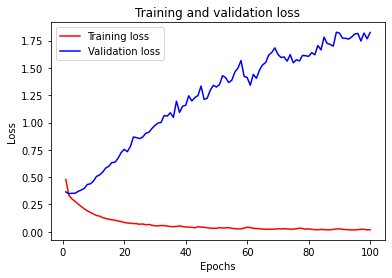

In [ ]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

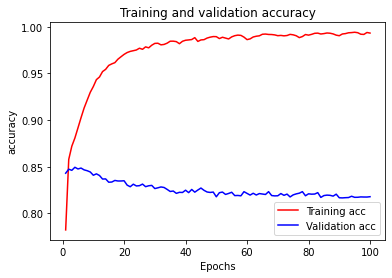

In [ ]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [4]:
model.save_weights('/content/')

NameError: ignored

In [5]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz

--2022-09-12 17:22:34--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-09-12 17:22:35--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean

In [6]:
!tar -xzvf korean-english-park.train.tar.gz

korean-english-park.train.en
korean-english-park.train.ko


In [9]:
naver_df = pd.read_table('/content/korean-english-park.train.ko')
naver_df.head()

,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?"""
0,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
1,그러나 이것은 또한 책상도 필요로 하지 않는다.
2,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
3,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...
4,이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러...


In [10]:
len(naver_df)

93126

In [11]:
naver_df.isnull().values.any()

False

In [ ]:
## 단어장 만들기

In [13]:
corpus = '/content/korean-english-park.train.ko' # 입력 corpus
prefix = 'ko_voca' # 저장할 단어장 이름
vocab_size = 8000
spm.SentencePieceTrainer.Train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size}" +
    "--model_type=bpe" +
    "--max_sentence_length=999999" #문장 최대 길이
)
naver_vocab_list = pd.read_csv('ko_voca.vocab', sep='\t', header = None, quoting=csv.QUOTE_NONE)
naver_vocab_list.sample(10)

,0,1
5034,▁본선,-10.45890
4095,300,-10.18230
5279,ell,-10.52430
6039,▁후진타오,-10.74140
6277,뇨,-10.81220
4878,▁소매,-10.41160
3286,▁남성이,-9.93085
7683,늑,-12.00690
6960,▁히틀러,-11.03760
2904,▁구호,-9.79886


In [62]:
# s = spm.SentencePieceProcessor()
# s.Load('korean_spm.model')
sp = spm.SentencePieceProcessor()
vocab_file = '/content/ko_voca.model'
sp.load(vocab_file)

def sp_tokenize(sp, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(sp.EncodeAsIds(sen))

    with open("/content/ko_voca.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre') #post에서 pre로 바꿔봄

    return tensor, word_index, index_word

In [15]:
sp.GetPieceSize()
len(naver_vocab_list)

8000

In [50]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

train_data_st = train_data.dropna(how='any')
test_data_st = test_data.dropna(how='any')

y_train1=np.array(list(train_data_st['label']))#타깃값 분리
y_test1=np.array(list(test_data_st['label']))

In [52]:
print(y_train1.shape)
print(y_test1.shape)
print(y_train1[:10])

(146182,)
(49157,)
[0 1 0 0 1 0 0 0 1 1]


In [63]:
sp = spm.SentencePieceProcessor()
vocab_file = '/content/ko_voca.model'
sp.load(vocab_file)

True

In [64]:
tensor_X, word_index_x, index_word_x=sp_tokenize(sp,train_data_st['document'])
tensor_Y, word_index_y, index_word_y=sp_tokenize(sp,test_data_st['document'])

In [65]:
print(type(tensor_X))
print(tensor_X[:10])
print(tensor_Y[:10])

<class 'numpy.ndarray'>
[[   0    0    0 ...  578  527 2666]
 [   0    0    0 ... 2491  241   66]
 [   0    0    0 ... 1071  785  239]
 ...
 [   0    0    0 ...  287 7721  578]
 [   0    0    0 ...  295  357  182]
 [   0    0    0 ... 1345   66  666]]
[[   0    0    0 ... 7893    3    0]
 [   0    0    0 ...  771 1863  658]
 [   0    0    0 ... 2464    0   97]
 ...
 [   0    0    0 ... 7854   82  239]
 [   0    0    0 ...  633  592  156]
 [   0    0    0 ...  578    4    4]]


In [35]:
print(tensor_X.shape)
print(tensor_Y.shape)

(146182, 140)
(49157, 140)


In [66]:
vocab_size = 8000
word_vector_dim = 200 # 2의 배수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         1600000   
                                                                 
 lstm_1 (LSTM)               (None, 8)                 6688      
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,606,769
Trainable params: 1,606,769
Non-trainable params: 0
_________________________________________________________________


In [67]:
x_val = tensor_X[:50000]
y_val = y_train1[:50000]

partial_x_train = tensor_X[50000:]
partial_y_train = y_train1[50000:]



In [68]:
print(partial_x_train.shape)
print(x_val.shape)

(96182, 140)
(50000, 140)


In [69]:
print(partial_y_train.shape)
print(y_val.shape)

(96182,)
(50000,)


In [70]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 100
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/100
188/188 [==============================] - 6s 25ms/step - loss: 0.5218 - accuracy: 0.7536 - val_loss: 0.4229 - val_accuracy: 0.8159
Epoch 2/100
188/188 [==============================] - 5s 24ms/step - loss: 0.3957 - accuracy: 0.8288 - val_loss: 0.3949 - val_accuracy: 0.8241
Epoch 3/100
188/188 [==============================] - 3s 15ms/step - loss: 0.3630 - accuracy: 0.8438 - val_loss: 0.3888 - val_accuracy: 0.8288
Epoch 4/100
188/188 [==============================] - 3s 15ms/step - loss: 0.3391 - accuracy: 0.8541 - val_loss: 0.3829 - val_accuracy: 0.8311
Epoch 5/100
188/188 [==============================] - 3s 15ms/step - loss: 0.3171 - accuracy: 0.8634 - val_loss: 0.3847 - val_accuracy: 0.8313
Epoch 6/100
188/188 [==============================] - 3s 17ms/step - loss: 0.2980 - accuracy: 0.8732 - val_loss: 0.3927 - val_accuracy: 0.8323
Epoch 7/100
188/188 [==============================] - 4s 19ms/step - loss: 0.2829 - accuracy: 0.8802 - val_loss: 0.3938 - val_accuracy:

In [71]:
results = model.evaluate(tensor_Y, y_test1, verbose=2)

1537/1537 - 6s - loss: 1.2589 - accuracy: 0.8019 - 6s/epoch - 4ms/step


In [72]:
print(results)

[1.2589150667190552, 0.8019407391548157]


In [73]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


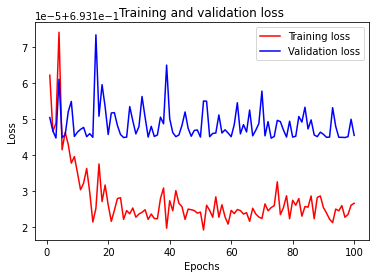

In [60]:
epochs = range(1, len(acc)+1)#post패드결과

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

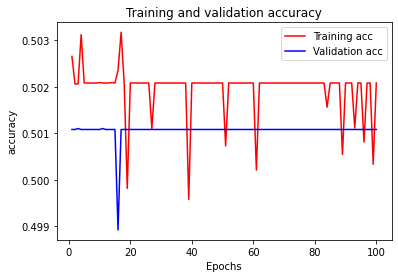

In [61]:
plt.clf() #그림을 초기화(post패드결과)

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

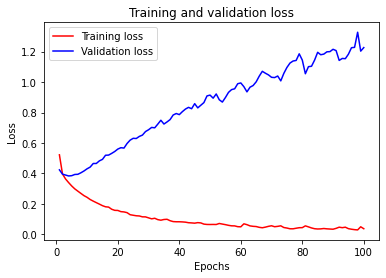

In [74]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

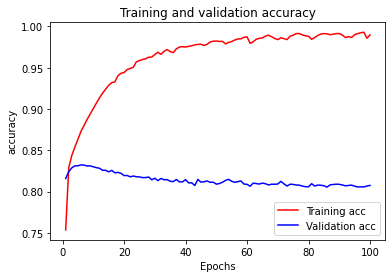

In [75]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()